# Chan-Vese segmentation algorithm demonstration

Explore the use of Chan-Vese active contours for image segmentation on a small sample of natural and medical images

Author: Jacob Reinhold

## Setup notebook

In [108]:
import os
import sys

from IPython.display import HTML
import matplotlib.pyplot as plt
from matplotlib import animation, rc
import numpy as np
from PIL import Image
from scipy.ndimage import distance_transform_edt as distance
from skimage import data, img_as_float
from skimage.color import rgb2gray
from skimage.draw import circle_perimeter
from skimage.filters import gaussian
from skimage.segmentation import chan_vese, active_contour

 Support in-notebook plotting

In [2]:
%matplotlib inline

Report versions

In [3]:
print('numpy version: {}'.format(np.__version__))
from matplotlib import __version__ as mplver
print('matplotlib version: {}'.format(mplver))

numpy version: 1.15.4
matplotlib version: 3.0.2


In [4]:
pv = sys.version_info
print('python version: {}.{}.{}'.format(pv.major, pv.minor, pv.micro))

python version: 3.7.1


Reload packages where content for package development

In [5]:
%load_ext autoreload
%autoreload 2

## Define helper functions

In [51]:
def plot_results(img, cv, rotn=3, figsize=(8,8)):
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    ax = axes.flatten()

    ax[0].imshow(np.rot90(img,rotn), cmap="gray")
    ax[0].set_axis_off()
    ax[0].set_title("Original Image", fontsize=12)

    ax[1].imshow(np.rot90(cv[0],rotn), cmap="gray")
    ax[1].set_axis_off()
    title = "Chan-Vese segmentation - {} iterations".format(len(cv[2]))
    ax[1].set_title(title, fontsize=12)

    ax[2].imshow(np.rot90(cv[1],rotn), cmap="gray")
    ax[2].set_axis_off()
    ax[2].set_title("Final Level Set", fontsize=12)

    ax[3].plot(np.array(cv[2])/1000)
    ax[3].set_title("Evolution of energy over iterations", fontsize=12)

    fig.tight_layout()

    
def animate(image, segs, interval=20):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(image, cmap='gray');
    im = ax.imshow(segs[0], alpha=0.5, cmap='inferno');
    ax.axis('off')

    def init():
        im.set_data(segs[0])
        return [im]

    def animate(i):
        im.set_array(segs[i])
        return [im]

    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=len(segs), interval=20, blit=True);
    return anim

## Compare and contrast edge-based active contour vs. Chan-Vese

### On Gaussian image

In [118]:
img = np.zeros((100, 100))
rr, cc = circle_perimeter(35, 45, 25)
img[rr, cc] = 1
img = gaussian(img, 10)

#### Edge-based

Kass, M.; Witkin, A.; Terzopoulos, D. “Snakes: Active contour models”. International Journal of Computer Vision 1 (4): 321 (1988). DOI:10.1007/BF00133570

In [119]:
s = np.linspace(0, 2*np.pi, 100)
init = 50 * np.array([np.cos(s), np.sin(s)]).T + 50
snake = active_contour(img, init, w_edge=0, w_line=1)

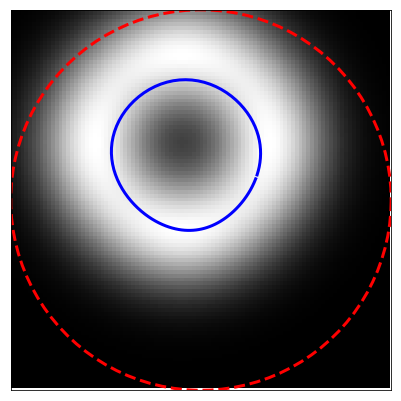

In [120]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(img, cmap=plt.cm.gray)
ax.plot(init[:, 0], init[:, 1], '--r', lw=3)
ax.plot(snake[:, 0], snake[:, 1], '-b', lw=3)
ax.set_xticks([]), ax.set_yticks([])
ax.axis([0, img.shape[1], img.shape[0], 0]);

#### Chan-Vese

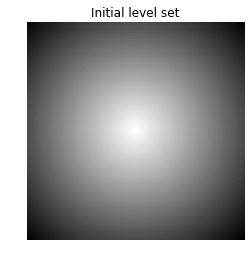

In [121]:
init = small_disk(img.shape, (49, 49), 40)
plt.imshow(init,cmap='gray'); plt.axis('off'); plt.title('Initial level set');

In [122]:
cv = chan_vese(img, mu=0.07, lambda1=1, lambda2=1, tol=1e-3, max_iter=500,
               dt=0.5, init_level_set=init, extended_output=True)

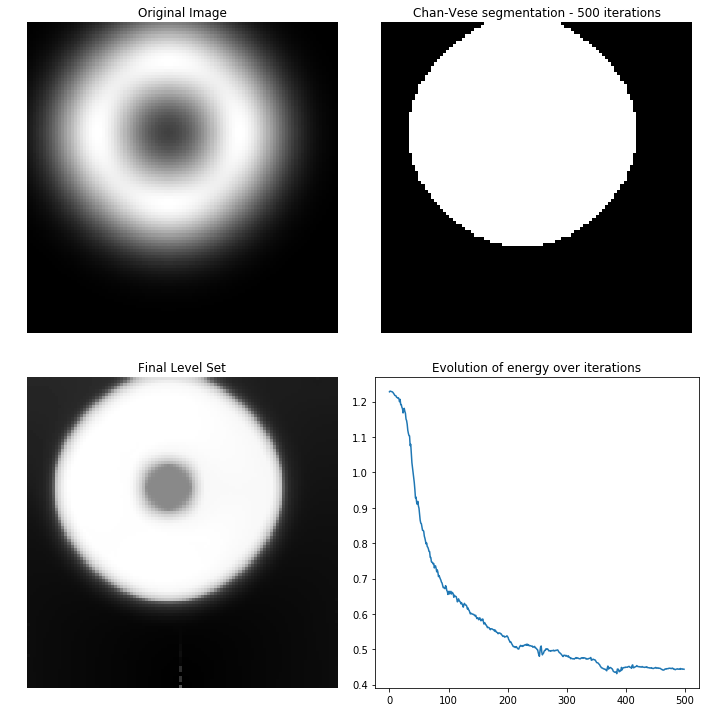

In [123]:
plot_results(img, cv, 0, (10,10))

### On Gaussian image with uniform noise in [0,1]

In [130]:
img = np.zeros((100, 100))
rr, cc = circle_perimeter(35, 45, 25)
img[rr, cc] = 1
img = gaussian(img, 10)
img += np.random.rand(*img.shape) * 0.01

#### Edge-based

In [131]:
s = np.linspace(0, 2*np.pi, 100)
init = 50 * np.array([np.cos(s), np.sin(s)]).T + 50
snake = active_contour(img, init, w_edge=0, w_line=1)

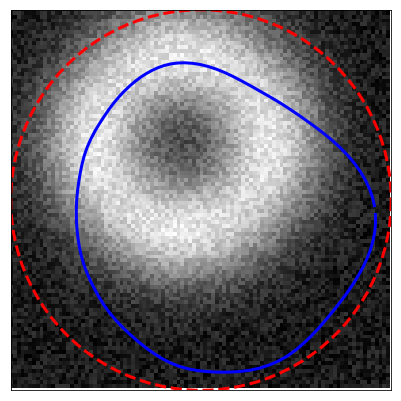

In [132]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(img, cmap=plt.cm.gray)
ax.plot(init[:, 0], init[:, 1], '--r', lw=3)
ax.plot(snake[:, 0], snake[:, 1], '-b', lw=3)
ax.set_xticks([]), ax.set_yticks([])
ax.axis([0, img.shape[1], img.shape[0], 0]);

#### Chan-Vese

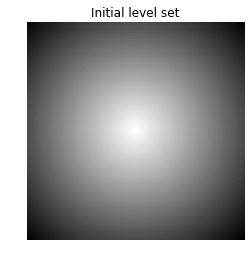

In [133]:
init = small_disk(img.shape, (49, 49), 40)
plt.imshow(init,cmap='gray'); plt.axis('off'); plt.title('Initial level set');

In [136]:
cv = chan_vese(img, mu=0.07, lambda1=1, lambda2=1, tol=1e-3, max_iter=5000,
               dt=0.5, init_level_set=init, extended_output=True)

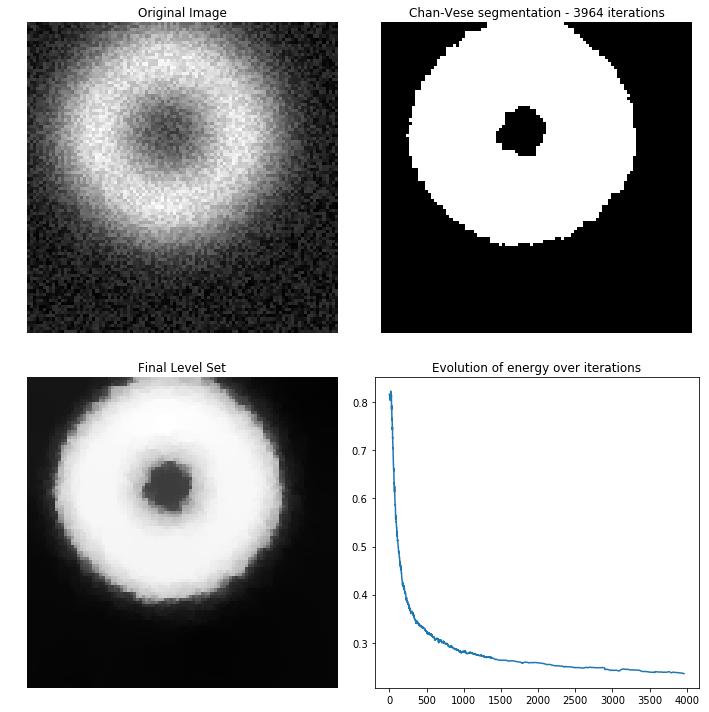

In [137]:
plot_results(img, cv, 0, (10,10))

## Test edge-based active contour on natural images

In [7]:
img = data.astronaut()
img = rgb2gray(img)

s = np.linspace(0, 2*np.pi, 400)
x = 220 + 100*np.cos(s)
y = 100 + 100*np.sin(s)
init = np.array([x, y]).T

snake = active_contour(gaussian(img, 3),
                       init, alpha=0.015, beta=10, gamma=0.001)

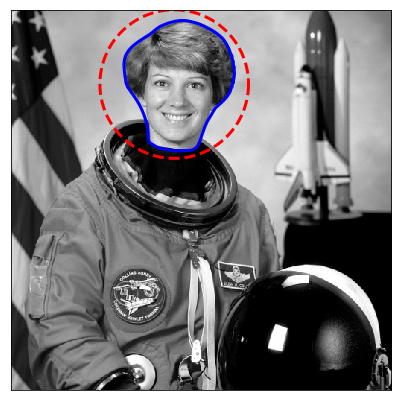

In [9]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(img, cmap=plt.cm.gray)
ax.plot(init[:, 0], init[:, 1], '--r', lw=3)
ax.plot(snake[:, 0], snake[:, 1], '-b', lw=3)
ax.set_xticks([]), ax.set_yticks([])
ax.axis([0, img.shape[1], img.shape[0], 0]);

## Test Chan-Vese on natural images

### Astronaut

#### Circle initialization (same as in the snake)

In [16]:
def small_disk(image_size, center, radius):
    centerX, centerY = center
    res = np.ones(image_size)
    res[centerY, centerX] = 0.
    return (radius-distance(res)) / (radius*3)

In [44]:
original = data.astronaut()
astro = rgb2gray(original)
image = img_as_float(astro)
init = small_disk(image.shape, (220, 100), 100)
cv = chan_vese(image, mu=0.07, lambda1=1, lambda2=1, tol=1e-3, max_iter=1,
               dt=0.5, init_level_set=init, extended_output=True)

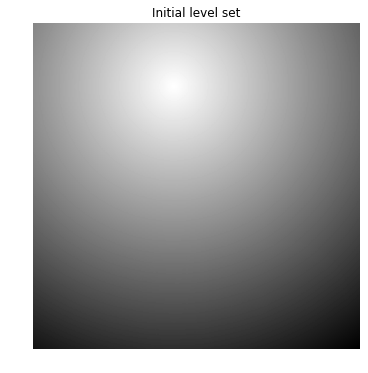

In [47]:
plt.figure(figsize=(6,6)); plt.imshow(cv[1],cmap='gray'); plt.title('Initial level set'); plt.axis('off');

In [30]:
original = data.astronaut()
astro = rgb2gray(original)
image = img_as_float(astro)
init = small_disk(image.shape, (220, 100), 100)
cv = chan_vese(image, mu=0.07, lambda1=1, lambda2=1, tol=1e-3, max_iter=5000,
               dt=0.5, init_level_set=init, extended_output=True)

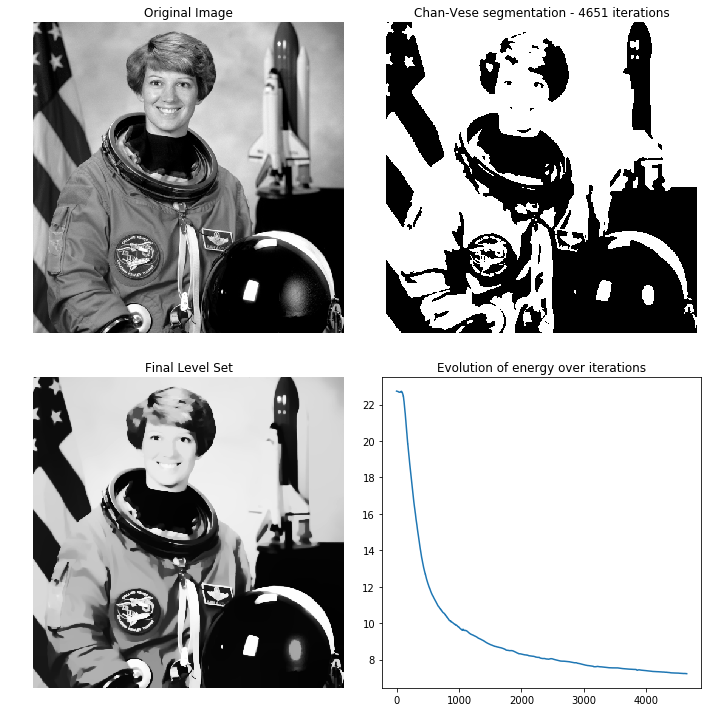

In [31]:
plot_results(image, cv, 0, (10,10))

In [ ]:
segs = np.load('circastro.npy')
anim = animate(image, segs);

In [58]:
HTML(anim.to_html5_video())

#### Checkerboard initialization

In [36]:
original = data.astronaut()
astro = rgb2gray(original)
image = img_as_float(astro)
cv = chan_vese(image, mu=0.07, lambda1=1, lambda2=1, tol=1e-3, max_iter=1,
               dt=0.5, init_level_set="checkerboard", extended_output=True)

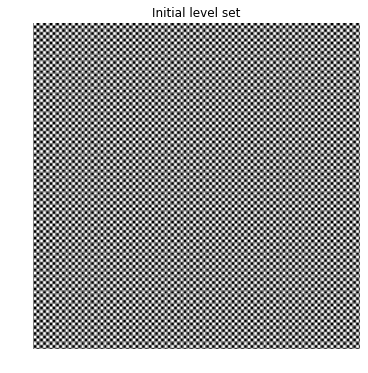

In [43]:
plt.figure(figsize=(6,6)); plt.imshow(cv[1],cmap='gray'); plt.title('Initial level set'); plt.axis('off');

In [32]:
original = data.astronaut()
astro = rgb2gray(original)
image = img_as_float(astro)
cv = chan_vese(image, mu=0.07, lambda1=1, lambda2=1, tol=1e-3, max_iter=5000,
               dt=0.5, init_level_set="checkerboard", extended_output=True)

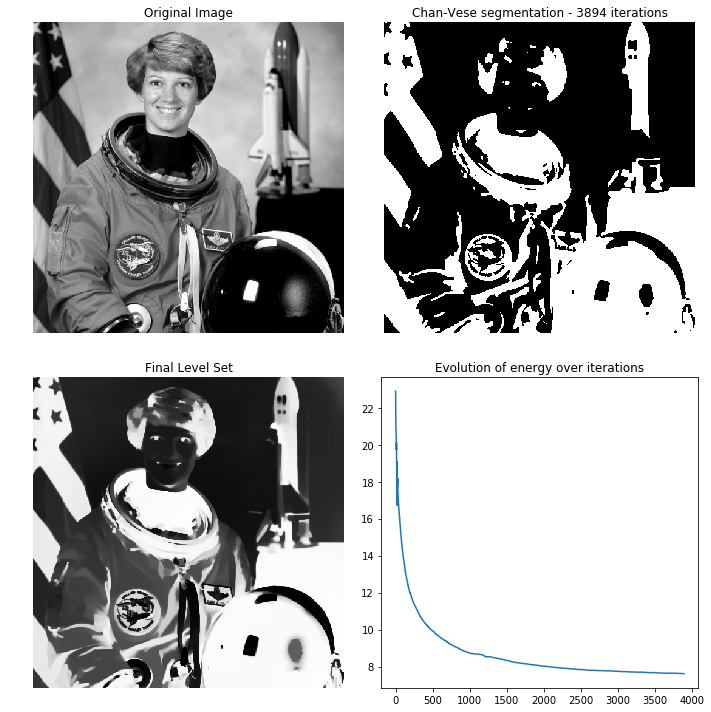

In [33]:
plot_results(image, cv, 0, (10,10))

In [ ]:
segs = np.load('astrosegs.npy')
anim = animate(image, segs);

In [55]:
HTML(anim.to_html5_video())

### Cameraman

In [11]:
image = img_as_float(data.camera())
cv = chan_vese(image, mu=0.25, lambda1=1, lambda2=1, tol=1e-3, max_iter=200,
               dt=0.5, init_level_set="checkerboard", extended_output=True)

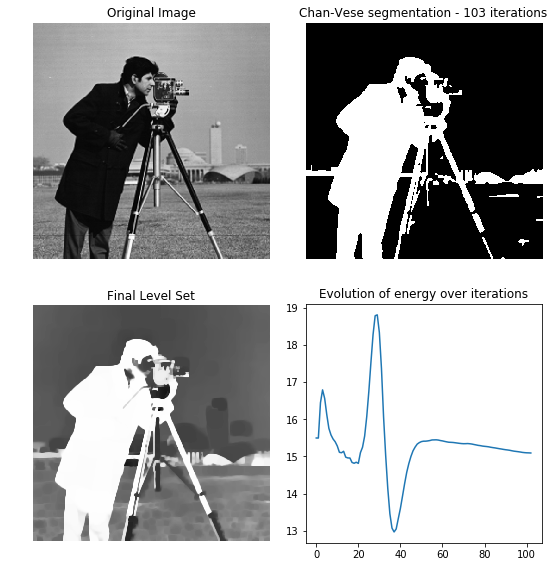

In [12]:
plot_results(image, cv, 0)

### Text on paper

In [22]:
image = img_as_float(data.text())
cv = chan_vese(image, mu=0.01, lambda1=1, lambda2=1, tol=1e-3, max_iter=5000,
               dt=0.5, init_level_set="checkerboard", extended_output=True)

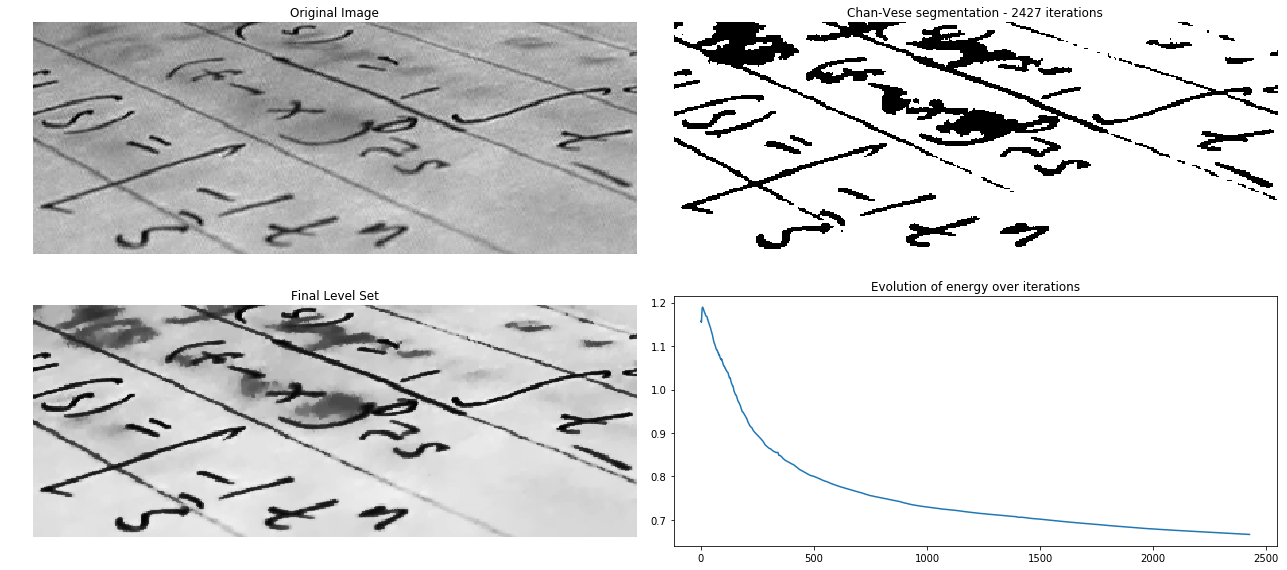

In [23]:
plot_results(image, cv, 0, (18,8))

## Test on medical image

### MR T1-w brain image

In [27]:
from glob import glob
fns = sorted(glob('imgs/*.tif'))
imgs = [Image.open(f) for f in fns]

In [28]:
def show(x,ax,t=''): ax.imshow(np.rot90(x,3),cmap='gray');ax.axis('off');ax.set_title(t);

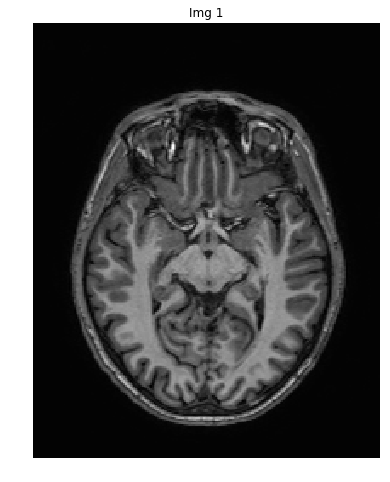

In [29]:
f, ax1 = plt.subplots(1,1,figsize=(12,8))
show(imgs[0],ax1,'Img 1');

In [30]:
img1, img2 = [np.asarray(im) for im in imgs]

In [31]:
cv = chan_vese(img1, mu=0.01, lambda1=1, lambda2=1, tol=1e-3, max_iter=5000,
               dt=0.5, init_level_set="checkerboard", extended_output=True)

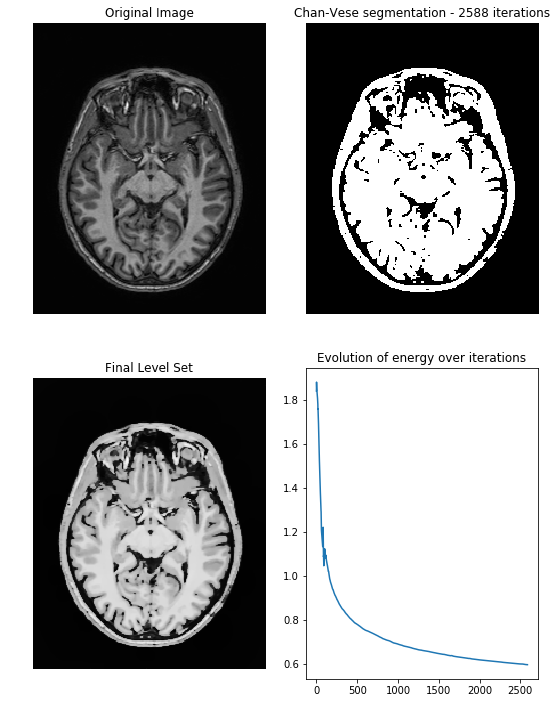

In [32]:
plot_results(img1, cv, 3, (8,10))